# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://course.cse.ust.hk/comp4901j/Password_Only/programs/assignment1/index.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm=LinearSVM()
        loss_hist=svm.train(X_train_feats,y_train,learning_rate=lr,reg=reg,num_iters=3000,batch_size=1000)
        y_train_pred=svm.predict(X_train_feats)
        y_val_pred=svm.predict(X_val_feats)
        train_accuracy=np.mean(y_train==y_train_pred)
        val_accuracy=np.mean(y_val==y_val_pred)
        if val_accuracy>best_val:
            best_val = val_accuracy
            best_svm = svm
        results[(lr, reg)] = (train_accuracy, val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.083327 val accuracy: 0.079000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.103347 val accuracy: 0.104000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.414959 val accuracy: 0.417000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.087041 val accuracy: 0.089000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.415184 val accuracy: 0.418000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.412224 val accuracy: 0.417000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.413735 val accuracy: 0.415000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.413755 val accuracy: 0.415000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.412796 val accuracy: 0.422000
best validation accuracy achieved during cross-validation: 0.422000


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.425


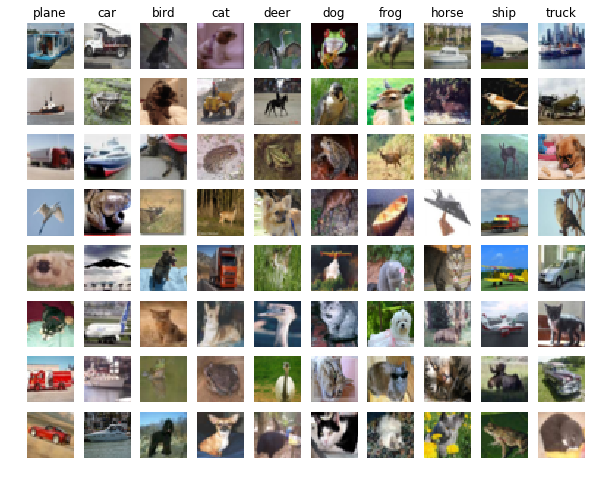

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


It makes sense because some objects from different class may have similar background colors, or their outlines are similar, which cause misclassification when we include HOG and color histogram as features.For example, planes photos at the right hand second column are classified as ship because their outlines are similar to ships with a blue sky background like ocean.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print(X_train_feats.shape)

(49000, 155)


hidden size: 500 learning rate: 0.3 number of iterations: 2000 regulation strength: 0.001 batch size: 200 Validation accuracy:  0.586
hidden size: 500 learning rate: 0.3 number of iterations: 2000 regulation strength: 0.001 batch size: 400 Validation accuracy:  0.585
hidden size: 500 learning rate: 0.3 number of iterations: 2000 regulation strength: 0.003 batch size: 200 Validation accuracy:  0.575
hidden size: 500 learning rate: 0.3 number of iterations: 2000 regulation strength: 0.003 batch size: 400 Validation accuracy:  0.581
hidden size: 500 learning rate: 0.5 number of iterations: 2000 regulation strength: 0.001 batch size: 200 Validation accuracy:  0.593
hidden size: 500 learning rate: 0.5 number of iterations: 2000 regulation strength: 0.001 batch size: 400 Validation accuracy:  0.599
hidden size: 500 learning rate: 0.5 number of iterations: 2000 regulation strength: 0.003 batch size: 200 Validation accuracy:  0.569
hidden size: 500 learning rate: 0.5 number of iterations: 2000

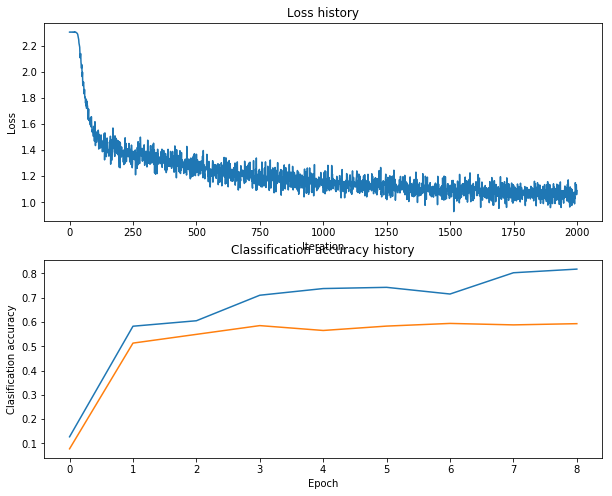

In [8]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
input_size=X_train_feats.shape[1]
num_classes=10

hidden_sizes=[500]
lrs=[3e-1,5e-1,7e-1]
epochnums=[2000]
regs=[1e-3,3e-3]
batch_sizes=[200,400]

hyperparams=[]
for hidden_size in hidden_sizes:
    for lr in lrs:
        for epochnum in epochnums:
            for reg in regs:
                for batch_size in batch_sizes:
                    hyperparams.append({'hidden_size':hidden_size,'lr':lr,'epoch_num':epochnum,'reg':reg,'batch_size':batch_size})

best_hyperparam={}
best_val=0
best_stats=None
for hyperparam in hyperparams:
    net = TwoLayerNet(input_size, hyperparam['hidden_size'], num_classes)

    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=hyperparam['epoch_num'], batch_size=hyperparam['batch_size'],
            learning_rate=hyperparam['lr'], learning_rate_decay=0.95,
            reg=hyperparam['reg'], verbose=False)

    # Predict on the validation set
    val_acc = (net.predict(X_val_feats) == y_val).mean()
    print('hidden size:',hyperparam['hidden_size'],'learning rate:',hyperparam['lr'],'number of iterations:',hyperparam['epoch_num'],'regulation strength:',hyperparam['reg'],'batch size:',hyperparam['batch_size'],'Validation accuracy: ',val_acc)
    if val_acc>best_val:
        best_net=net
        best_val=val_acc
        best_stats=stats
        best_hyperparam=hyperparam
print('finished, best hyperparam settings:')
print('hidden size:',best_hyperparam['hidden_size'])
print('learning rate:',best_hyperparam['lr'])
print('number of iterations:',best_hyperparam['epoch_num'])
print('regulation strength:',best_hyperparam['reg'])
print('batch size:',best_hyperparam['batch_size'])

print('\nTraining of Best model:')
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [9]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.572


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.


# Bonus: 

Here we want to see the difference in accuracy by changing the number of color bins from 1 to 50. Below are the results:

In [10]:

nums_color_bins=[1,2,3,4,5,10,20,30,40,50]
#nums_color_bins=[1,2,3]
datas=[]
for num_color_bin in nums_color_bins:
    feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
    X_train_feats = extract_features(X_train, feature_fns, verbose=False)
    X_val_feats = extract_features(X_val, feature_fns)
    X_test_feats = extract_features(X_test, feature_fns)

    # Preprocessing: Subtract the mean feature
    mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
    X_train_feats -= mean_feat
    X_val_feats -= mean_feat
    X_test_feats -= mean_feat

    # Preprocessing: Divide by standard deviation. This ensures that each feature
    # has roughly the same scale.
    std_feat = np.std(X_train_feats, axis=0, keepdims=True)
    X_train_feats /= std_feat
    X_val_feats /= std_feat
    X_test_feats /= std_feat

    # Preprocessing: Add a bias dimension
    X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
    X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
    X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
    
    datas.append({'num':num_color_bin,'train':X_train_feats,'val':X_val_feats,'test':X_test_feats})
    print('color bins finished so far =',num_color_bin)


color bins finished so far = 1
color bins finished so far = 2
color bins finished so far = 3
color bins finished so far = 4
color bins finished so far = 5
color bins finished so far = 10
color bins finished so far = 20
color bins finished so far = 30
color bins finished so far = 40
color bins finished so far = 50


Num of color bins:  1
Validation accuracy:  0.571
Test accuracy:  0.555
Num of color bins:  2
Validation accuracy:  0.581
Test accuracy:  0.565
Num of color bins:  3
Validation accuracy:  0.582
Test accuracy:  0.562
Num of color bins:  4
Validation accuracy:  0.571
Test accuracy:  0.544
Num of color bins:  5
Validation accuracy:  0.576
Test accuracy:  0.554
Num of color bins:  10
Validation accuracy:  0.588
Test accuracy:  0.57
Num of color bins:  20
Validation accuracy:  0.569
Test accuracy:  0.571
Num of color bins:  30
Validation accuracy:  0.583
Test accuracy:  0.562
Num of color bins:  40
Validation accuracy:  0.578
Test accuracy:  0.57
Num of color bins:  50
Validation accuracy:  0.579
Test accuracy:  0.566


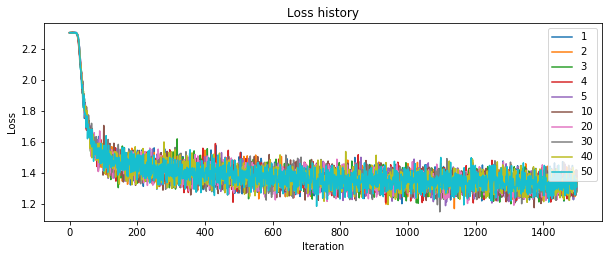

In [11]:


for data in datas:
    input_dim = data['train'].shape[1]
    hidden_dim = 500
    num_classes = 10
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

    # Train the network
    stats = net.train(data['train'], y_train, data['val'], y_val,
            num_iters=1500, batch_size=400,
            learning_rate=0.7, learning_rate_decay=0.95,
            reg=0.003, verbose=False)

    # Predict on the validation set
    print('Num of color bins: ',data['num'])
    val_acc = (net.predict(data['val']) == y_val).mean()
    print('Validation accuracy: ', val_acc)
    test_acc = (net.predict(data['test']) == y_test).mean()
    print('Test accuracy: ',test_acc)
    plt.subplot(2, 1, 1)

    plt.plot(stats['loss_history'] , label= data['num'])   
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

The result shows that the test accuracies are similar no matter how many color bins there are. Number of color bins would not affect the accuracies is the conclusion drawn here. 

# Bonus:  

Now, we try comparing performance by using new features of Color histogram, HOG , and HOG + Color histogram together respectively. Below are the results:

Data type(features): HOG + color histogram
Validation accuracy: 0.58
Test accuracy: 0.572
Data type(features): HOG
Validation accuracy: 0.531
Test accuracy: 0.551
Data type(features): color histogram
Validation accuracy: 0.287
Test accuracy: 0.25


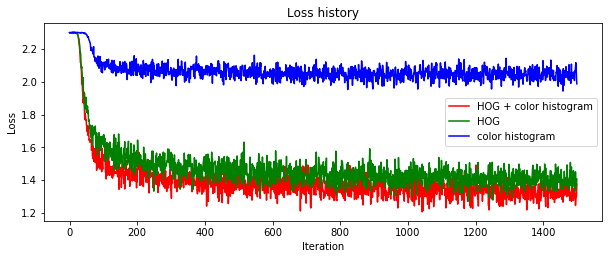

In [12]:


from cs231n.features import *
from cs231n.classifiers.neural_net import TwoLayerNet


num_color_bins = 10 # Number of bins in the color histogram
feature_fns_both = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
feature_fns_hog=[hog_feature]
feature_fns_hsv=[lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

X_train_feats_both = extract_features(X_train, feature_fns_both, verbose=False)
X_val_feats_both = extract_features(X_val, feature_fns_both)
X_test_feats_both = extract_features(X_test, feature_fns_both)
X_train_feats_hog = extract_features(X_train, feature_fns_hog, verbose=False)
X_val_feats_hog = extract_features(X_val, feature_fns_hog)
X_test_feats_hog = extract_features(X_test, feature_fns_hog)
X_train_feats_hsv = extract_features(X_train, feature_fns_hsv, verbose=False)
X_val_feats_hsv = extract_features(X_val, feature_fns_hsv)
X_test_feats_hsv = extract_features(X_test, feature_fns_hsv)







def preprocess(X_train_feats,X_val_feats,X_test_feats):
    # Preprocessing: Subtract the mean feature
    mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
    X_train_feats -= mean_feat
    X_val_feats -= mean_feat
    X_test_feats -= mean_feat

    # Preprocessing: Divide by standard deviation. This ensures that each feature
    # has roughly the same scale.
    std_feat = np.std(X_train_feats, axis=0, keepdims=True)
    X_train_feats /= std_feat
    X_val_feats /= std_feat
    X_test_feats /= std_feat

    # Preprocessing: Add a bias dimension
    X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
    X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
    X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
    
    return X_train_feats,X_val_feats,X_test_feats

X_train_feats_both,X_val_feats_both,X_test_feats_both=preprocess(X_train_feats_both,X_val_feats_both,X_test_feats_both)
X_train_feats_hog,X_val_feats_hog,X_test_feats_hog=preprocess(X_train_feats_hog,X_val_feats_hog,X_test_feats_hog)
X_train_feats_hsv,X_val_feats_hsv,X_test_feats_hsv=preprocess(X_train_feats_hsv,X_val_feats_hsv,X_test_feats_hsv)

data_both={'type':'HOG + color histogram','train':X_train_feats_both,'val':X_val_feats_both,'test':X_test_feats_both}
data_hog={'type':'HOG','train':X_train_feats_hog,'val':X_val_feats_hog,'test':X_test_feats_hog}
data_hsv={'type':'color histogram','train':X_train_feats_hsv,'val':X_val_feats_hsv,'test':X_test_feats_hsv}
datas=[data_both,data_hog,data_hsv]

for data in datas:
    input_dim = data['train'].shape[1]
    hidden_dim = 500
    num_classes = 10
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

    # Train the network
    stats = net.train(data['train'], y_train, data['val'], y_val,
            num_iters=1500, batch_size=400,
            learning_rate=0.7, learning_rate_decay=0.95,
            reg=0.003, verbose=False)

    # Predict on the validation set
    print('Data type(features):',data['type'])
    val_acc = (net.predict(data['val']) == y_val).mean()
    print('Validation accuracy:', val_acc)
    test_acc = (net.predict(data['test']) == y_test).mean()
    print('Test accuracy:',test_acc)
    
    
    plt.subplot(2, 1, 1)
    if data['type']=='HOG + color histogram': 
        plt.plot(stats['loss_history'] ,'r', label='HOG + color histogram')
    if data['type']=='HOG':    
        plt.plot(stats['loss_history'] ,'g', label='HOG')
    if data['type']=='color histogram': 
        plt.plot(stats['loss_history'] ,'b', label='color histogram')   
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    
    

    




We see that using both HOG and Color histogram as features give highest test accuracy with 0.563, while HOG alone give far higher accuracy than using color histogram as feature. This may be due to the fact that image shape is more important than colors in image classification.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

# Bonus:  

Below we Use TSNE to reduce the data into 3-dimensions and visualize the distribution of 6 of the classes of the testing data. 


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA, FastICA
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import euclidean
import numpy as np

In [39]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

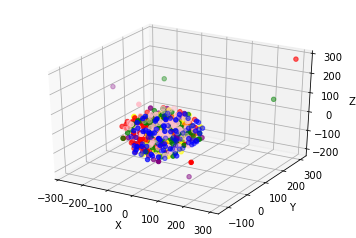

In [40]:

#Use TSNE to cluster and visiulize them
from sklearn.manifold  import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_embedded = TSNE(n_components=3).fit_transform(X_test)

#test_TSNE = doTSNE(X_test)
points = X_embedded[:, 0:6]
category_0 = points[np.where(y_test==0)]
category_1 = points[np.where(y_test==1)]
category_2 = points[np.where(y_test==2)]
category_3 = points[np.where(y_test==3)]
category_4 = points[np.where(y_test==4)]
category_5 = points[np.where(y_test==5)]




fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(category_0[:, 0], category_0[:, 1], category_0[:, 2], c='r')
ax.scatter(category_1[:, 0], category_1[:, 1], category_1[:, 2], c='b')
ax.scatter(category_2[:, 0], category_2[:, 1], category_2[:, 2], c='g')
ax.scatter(category_3[:, 0], category_3[:, 1], category_3[:, 2], c='yellow')
ax.scatter(category_4[:, 0], category_4[:, 1], category_4[:, 2], c='purple')
ax.scatter(category_5[:, 0], category_5[:, 1], category_5[:, 2], c='pink')




ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()




/Users/lukwingsan/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


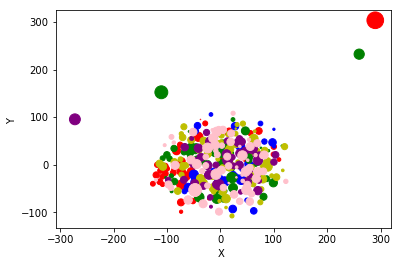

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
#ax = Axes(fig, rect=[0, 0, .95, 1], elev=45, azim=134)
ax.scatter(category_0[:, 0], category_0[:, 1], category_0[:, 2], c='r')
ax.scatter(category_1[:, 0], category_1[:, 1], category_1[:, 2], c='b')
ax.scatter(category_2[:, 0], category_2[:, 1], category_2[:, 2], c='g')
ax.scatter(category_3[:, 0], category_3[:, 1], category_3[:, 2], c='y')
ax.scatter(category_4[:, 0], category_4[:, 1], category_4[:, 2], c='purple')
ax.scatter(category_5[:, 0], category_5[:, 1], category_5[:, 2], c='pink')


ax.set_xlabel('X ')
ax.set_ylabel('Y ')

plt.show()

From the visualization, we see that all different groups of clustered data are mixed together. No specific distinct clusters exist. This specifies that tsne is not useful for classify images.